# Barrier Reef Detectron2 [Training]

### Hi kagglers, This is `Training` notebook using `Detetron2`.


### Other notebooks in the competition
- [Barrier Reef Detecrton2 [Inference]](https://www.kaggle.com/ammarnassanalhajali/barrier-reef-detectron2-inference)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# 📚 Detectron2
Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark

#  ⬇️ Install Detectron2

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd 

from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional
import json
import matplotlib.pyplot as plt
import shutil
import ast


from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
#import numba
#from numba import jit

from pycocotools.coco import COCO
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset



from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

setup_logger()

# 🔨 Functions

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# 🍮 Loading Data

In [ ]:
# --- Read data ---
TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'
# Read in the data CSV files
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df.head(5)


# BBoxes
##### 📌 Note 
> We can see there are many images without any BBox. 

In [ ]:
df["NumBBox"]=df['annotations'].apply(lambda x: str.count(x, 'x'))
df.head(5)

In [ ]:
print(df["NumBBox"].unique())

In [ ]:
df_train=df[df["NumBBox"]>0]
df_train.sample(2)

In [ ]:
print(df_train['NumBBox'].sum())

> We have just 4919 images with 11898 BBox, we will use them in training.

In [ ]:
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)
df_train.sample(2)

# Size of Images
##### 📌 Note 
> All images have Width=1280 & Height=720 

In [ ]:
df_train["Width"]=1280
df_train["Height"]=720
df_train.sample(2)

# Path of Images

In [ ]:
df_train = df_train.progress_apply(get_path, axis=1)
df_train.sample(2)

# 🍚 Splitting Dataset

In [ ]:
Selected_Fold=0 #0..4
filename="A_Fold"+ str(Selected_Fold) +"_v12_R_50"

from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())


In [ ]:
def get_data_dicts(
    _train_df: pd.DataFrame,
    debug: bool = False,
    data_type:str="train"
   
):

    if debug:
        _train_df = _train_df.iloc[:10]  # For debug...
    dataset_dicts = []
    if data_type=="train":
        _train_df=_train_df[_train_df.fold != Selected_Fold]
    else: # val
        _train_df=_train_df[_train_df.fold == Selected_Fold] 
        
    for index, row in tqdm(_train_df.iterrows(), total=len(_train_df)):
        record = {}
        filename  = row.image_path #filename = str(f'{imgdir}/{image_id}.png')
        image_id = row.image_id
        image_height= row.Height
        image_width = row.Width
        bboxes_coco = row.bboxes
        #bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
        record["file_name"] = filename
        record["image_id"] = image_id
        record["width"] = image_width
        record["height"] = image_height
        objs = []
        class_id = 0
        iscrowd=0
        for bbox_idx in range(len(bboxes_coco)):
            bbox=bboxes_coco[bbox_idx]
            obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "category_id": class_id,
                    "area": int(bbox[2])*int(bbox[3]),
                    "iscrowd": iscrowd
                }
            objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
thing_classes=['starfish']
debug=False

Data_Resister_training="BR_data_train";
Data_Resister_valid="BR_data_valid";


DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    

dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

# 🌈 Visualizing BBoxes
It's also very easy to visualize prepared training dataset with detectron2.
It provides Visualizer class, we can use it to draw an image with bounding box as following.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize =(35,20))
i=-1
for d in random.sample(dataset_dicts_valid, 2):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, :],
                   metadata=metadata_dicts_train, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].imshow(out.get_image()[:, :, ::-1])

# Evaluator

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    """
    This function is taken from
    competition metric implementation
    https://www.kaggle.com/bamps53/competition-metric-implementation
    Thanks:Camaro
    """
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    enc_targs = list(map(lambda x:x['bbox'], targ))
    
    enc_preds = pred['instances'].pred_boxes.tensor.cpu().numpy()
    enc_preds = BoxMode.convert(enc_preds, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    enc_preds = enc_preds.tolist()
    
    #ious = calc_iou(np.asarray(enc_preds[:len(enc_targs)]),np.asarray(enc_targs))
    ious = calc_iou(np.asarray(enc_preds),np.asarray(enc_targs))
    #res = {score[i]: boxes[i] for i in range(len(score))}
    #a = sorted(res.items(), key=lambda x: x[0])
    beta=2
    prec = []
    for t in np.arange(0.30, 0.85, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p= (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)
        prec.append(p)
    return np.mean(prec)

class F2ScoreEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"F2 Score": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return F2ScoreEvaluator(dataset_name)
        #return COCOEvaluator(dataset_name, cfg, True, output_folder)
        
    def build_hooks(self):
        cfg = self.cfg.clone()
        hooks = super().build_hooks()
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD,
                                          DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "F2 Score",
                                         "max",
                                         ))
        return hooks

# Albumentation

In [ ]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.8, 1.2),
           # T.RandomContrast(0.8, 1.2),
          #  T.RandomSaturation(0.8, 1.2),
          #  T.RandomLighting(0.8),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return F2ScoreEvaluator(dataset_name)

    def build_hooks(self):
        cfg = self.cfg.clone()
        hooks = super().build_hooks()
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD,
                                          DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "F2 Score",
                                         "max",
                                         ))
        return hooks

# Training

In [ ]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"  

cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)


cfg.MODEL.WEIGHTS ="../input/barrier-reef-detectron2-rs/output/model_best.pth"
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32  # 64 is slower but more accurate (128 faster but less accurate)


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class  + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1 # only has one class  + 1

cfg.SOLVER.IMS_PER_BATCH = 4 #(2 is per defaults)
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.5
#cfg.SOLVER.MOMENTUM = 0.938
#cfg.SOLVER.WEIGHT_DECAY = 0.0005

    
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 2000 #Maximum of iterations 1
#cfg.SOLVER.STEPS = (3000,4500) #At which point to change the LR 0.25,0.5

cfg.TEST.EVAL_PERIOD = 50
#cfg.SOLVER.CHECKPOINT_PERIOD=100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluator
* Famouns dataset's evaluator is already implemented in detectron2.
* For example, many kinds of AP (Average Precision) are calculted in COCOEvaluator.
* COCOEvaluator calculates AP with IoU from 0.50 to 0.95
### I added F2ScoreEvaluator
* F2ScoreEvaluator calculates F2 Score with IoU from 0.30 to 0.80

In [ ]:
print('################################################################')
print('################### test the best model: F2 Score ##################')
print('################################################################')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = F2ScoreEvaluator(Data_Resister_valid)
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
FS_bm=inference_on_dataset(predictor.model, val_loader, evaluator)['F2 Score']
print("F2 Score for best model=",FS_bm)

print('################################################################')
print('################### test the best model : AP@50-95 ##################')
print('################################################################')
evaluator = COCOEvaluator(Data_Resister_valid, output_dir="./output")
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
AP_bm=inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']['AP']
print("AP for best model=",AP_bm)

print('################################################################')
print('################## test the final model: F2 Score ##################')
print('################################################################')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = F2ScoreEvaluator(Data_Resister_valid)
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
FS_fm=inference_on_dataset(predictor.model, val_loader, evaluator)['F2 Score']
print("F2 Score for the final model=",FS_fm)
print('################################################################')
print('################## test final model: AP@50-95 ##################')
print('################################################################')
evaluator = COCOEvaluator(Data_Resister_valid, output_dir="./output")
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
AP_fm=inference_on_dataset(predictor.model, val_loader, evaluator)['bbox']['AP']
print("AP for the final model=",AP_fm)

In [ ]:
print("F2 Score for the best model=",FS_bm)
print("F2 Score for the final model=",FS_fm)
print("AP for the best model=",AP_bm)
print("AP for the final model=",AP_fm)

# Curves

In [ ]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines
experiment_metrics = load_json_arr('./output/metrics.json')

iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]


iters_loss_box_reg = [x['iteration'] for x in experiment_metrics if 'loss_box_reg' in x]
loss_box_reg = [x['loss_box_reg'] for x in experiment_metrics if 'loss_box_reg' in x]

iters_AP = [x['iteration'] for x in experiment_metrics if 'F2 Score' in x]
AP = [x['F2 Score'] for x in experiment_metrics if 'F2 Score' in x]

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(iters_total_loss, total_loss)
ax[0].plot(iters_loss_box_reg, loss_box_reg)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend(['total_loss', 'loss_box_reg'], loc='best')

iter = loss_box_reg.index(min(loss_box_reg))
ax[0].vlines(iters_loss_box_reg[iter], 0, float(max(loss_box_reg)),color="red",linestyles ="dashed")
ax[0].annotate('min loss_box_reg: %f at iter: %d'%(float(min(loss_box_reg)),int(iters_loss_box_reg[iter])),xy=(iters_loss_box_reg[iter],min(loss_box_reg)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

iter = total_loss.index(min(total_loss))
ax[0].vlines(iters_total_loss[iter], 0, float(max(total_loss)),color="blue",linestyles ="dashed")
ax[0].annotate('min total_loss: %f at iter: %d'%(float(min(total_loss)),int(iters_total_loss[iter])),xy=(iters_total_loss[iter],min(total_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_loss_box_reg))])
ax[0].set_ylim([0,max(1.5*max(total_loss),1.5*max(loss_box_reg))])
#ax[0].legend(bbox_to_anchor=(1.0, 1.0))

ax[1].plot(iters_AP, AP)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('F2 Score')
iter = AP.index(max(AP))
ax[1].vlines(iters_AP[iter], 0, 5+float(max(AP)),color="blue",linestyles ="dashed")
ax[1].annotate('max F2 Score: %f at iter: %d'%(float(max(AP)),int(iters_AP[iter])),xy=(iters_AP[iter],max(AP)),xytext=(+10,+10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
ax[1].set_xlim([0,max(iters_AP)])
ax[1].set_ylim([0,max(AP)*1.3])

fig.tight_layout()  
plt.show()

# Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor = DefaultPredictor(cfg)

fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_dicts_valid, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, :],
                   metadata=metadata_dicts_valid, 
                   scale=1 # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [ ]:
src="/kaggle/working/output/model_best.pth"
dst="/kaggle/working/"+str(filename)+"_F2S"+str(format(FS_bm,'.3f'))+"_AP"+ str(format(AP_bm,'.3f')) +"_best.pth"
shutil.copy(src,dst)

In [ ]:
src="/kaggle/working/output/model_final.pth"
dst="/kaggle/working/"+str(filename)+"_F2S"+str(format(FS_fm,'.3f'))+"_AP"+ str(format(AP_fm,'.3f')) +"_final.pth"
shutil.copy(src,dst)

In [ ]:
src="/kaggle/working/output/metrics.json"
dst="/kaggle/working/metrics.json"
shutil.copy(src,dst)

In [ ]:
path = "/kaggle/working/output"
shutil.rmtree(path)

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

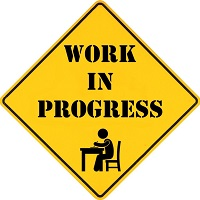